<a href="https://colab.research.google.com/github/oakhtar147/ham10000/blob/main/models/decision-tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
import itertools

from sklearn import model_selection
from sklearn import tree
from sklearn import metrics

% matplotlib inline
plt.style.use('classic')

In [ ]:
DATA_PATH = '/content/drive/My Drive/HAM/data'

In [ ]:
df = pd.read_csv(os.path.join(DATA_PATH, 'HAM10000_metadata.csv'))
df.rename(columns={'dx': 'targets', 'dx_type': 'diagnosis_type'}, inplace=True)
# drop the lesion_id column since it is insignificant
df.drop(columns=['lesion_id', 'image_id'], inplace=True)
df.head()

,targets,diagnosis_type,age,sex,localization
0,bkl,histo,80.0,male,scalp
1,bkl,histo,80.0,male,scalp
2,bkl,histo,80.0,male,scalp
3,bkl,histo,80.0,male,scalp
4,bkl,histo,75.0,male,ear


In [ ]:
target_maps = {
            'bkl': 'benign keratosis-like',
            'nv': 'nevi',
            'df': 'dermatofibroma',
            'mel': 'melanoma',
            'vasc': 'vascular regions',
            'bcc': 'basal cell carcinoma',
            'akiec': 'Bowen\'s disease'
        }

df['targets'] = df['targets'].map(target_maps)     
df.head()   

,targets,diagnosis_type,age,sex,localization
0,benign keratosis-like,histo,80.0,male,scalp
1,benign keratosis-like,histo,80.0,male,scalp
2,benign keratosis-like,histo,80.0,male,scalp
3,benign keratosis-like,histo,80.0,male,scalp
4,benign keratosis-like,histo,75.0,male,ear


In [ ]:
def fill_na(df, cols: list, fill='mean'):
    for col in cols:
        fill_types = {
            'mean':df[col].mean(),
            'mode': df[col].mode(),
            'median': df[col].median()
        }

        if fill in fill_types.keys(): 
                df[col].fillna(value=fill_types[fill], inplace=True)

        else:
            raise Exception('I cannot understand that fill_type!')      

        if col not in df.columns:
            raise Exception('Column not found!')

In [ ]:
fill_na(df=df, cols=['age'], fill='mean')

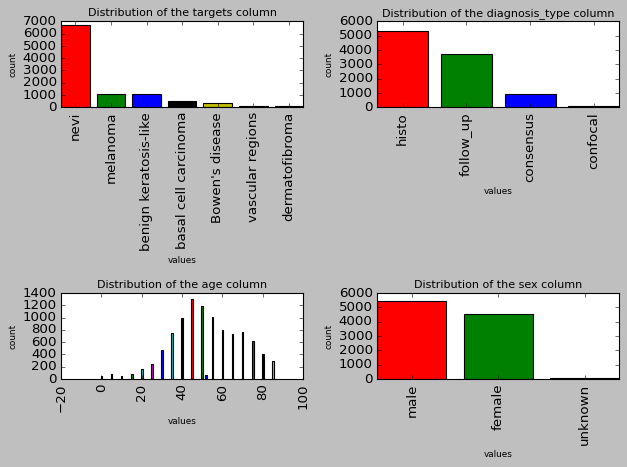

In [ ]:
fontsize = 10
for i, col in enumerate(['targets', 'diagnosis_type', 'age', 'sex']):
    i+=1
    target_counts = df[col].value_counts()
    targets = df[col].value_counts().index
    plt.subplot(2, 2, i)
    plt.bar(x=targets, height=target_counts, color=[*'rgbkymc'])
    plt.xticks(rotation='vertical')
    plt.xlabel('values', fontsize=fontsize-2)
    plt.ylabel('count', fontsize=fontsize-2)
    plt.title(f'Distribution of the {col} column', fontsize=fontsize)
    plt.tight_layout()

In [ ]:
dict(zip(df.targets.unique(), range(df.targets.nunique())))

{"Bowen's disease": 6,
 'basal cell carcinoma': 5,
 'benign keratosis-like': 0,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevi': 1,
 'vascular regions': 4}

In [ ]:
def convert_categorical_features(df):
    num_targets = df.targets.nunique()
    targets = df.targets.unique()
    df['targets'] = df['targets'].map(dict(zip(targets, range(num_targets))))

    categorical_columns = ['diagnosis_type', 'localization', 'sex']
    for col in categorical_columns:
        dummies = pd.get_dummies(df[col], drop_first=True)
        df = pd.concat([df, dummies], axis=1)

    df.drop(columns=categorical_columns, inplace=True)    

    return df

In [ ]:
df = convert_categorical_features(df)
df.head()

,targets,age,consensus,follow_up,histo,acral,back,chest,ear,face,foot,genital,hand,lower extremity,neck,scalp,trunk,unknown,upper extremity,male,unknown
0,0,80.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0,80.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0,80.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,0,80.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,75.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
def create_folds(save_path, n_splits=5, shuffle=True, save=False):

    # create a kfold column and fill with any value
    df["kfold"] = -1

    y = df.targets.values

    # create a stratified kfold object
    skf = model_selection.StratifiedKFold(n_splits=n_splits,
                                          shuffle=True,
                                          random_state=42 if shuffle else None)

    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=y)):
        df.loc[val_idx, "kfold"] = fold

    if save:        
        df.to_csv(save_path, index=False)    

    return df    

In [ ]:
df = create_folds(n_splits=5,
                  save_path=os.path.join(DATA_PATH, 'folds.csv'),
                  shuffle=True,
                  save=True)
df.head()

,targets,age,consensus,follow_up,histo,acral,back,chest,ear,face,foot,genital,hand,lower extremity,neck,scalp,trunk,unknown,upper extremity,male,unknown,kfold
0,0,80.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,2
1,0,80.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,4
2,0,80.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,2
3,0,80.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,2
4,0,75.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1


Text(0.5, 1.0, 'Distribution of target samples in a fold')

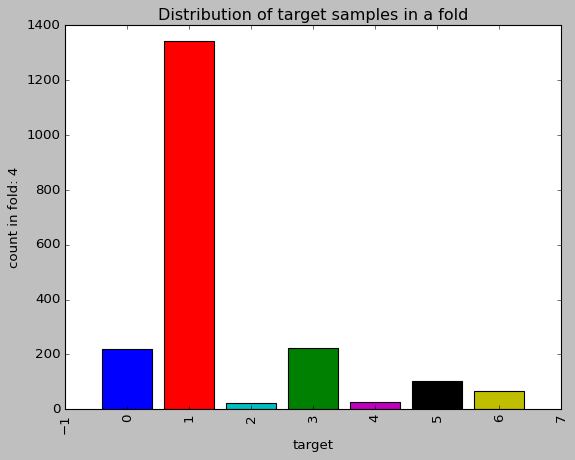

In [ ]:
fold = 4
plt.bar(x=df['targets'].value_counts().index,
        height=df[df['kfold'] == fold]['targets'].value_counts(),
        color=[*'rgbkymc'])
plt.xticks(rotation='vertical')
plt.xlabel('target')
plt.ylabel(f'count in fold: {fold}')
plt.title('Distribution of target samples in a fold')
# we have now created folds that have the same ratio of each class. 
# still the 'nv' class is very biased and we might have to downsample it

In [ ]:
df[df.kfold != 4].head()

,targets,age,consensus,follow_up,histo,acral,back,chest,ear,face,foot,genital,hand,lower extremity,neck,scalp,trunk,unknown,upper extremity,male,unknown,kfold
0,0,80.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,2
2,0,80.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,2
3,0,80.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,2
4,0,75.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
5,0,75.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2


In [ ]:
def train(df, fold, max_depth=5, return_pred=False):

    X_train = df[df['kfold'] != fold].drop(columns=['targets'])
    y_train = df[df['kfold'] != fold]['targets']
    X_val  =  df[df['kfold'] == fold].drop(columns=['targets'])
    y_val =   df[df['kfold'] == fold]['targets']

    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X_train, y_train)

    train_pred = clf.predict(X_train)
    val_pred = clf.predict(X_val)

    train_acc = metrics.accuracy_score(y_train, train_pred)
    val_acc = metrics.accuracy_score(y_val, val_pred)

    if return_pred:
        return train_acc, train_pred, val_acc, val_pred
        
    return train_acc, val_acc

In [ ]:
def aggregate_fold_accuracies(train_accuracies, val_accuracies, mode="mean"):
    
    aggregations = {
                'mean': (np.mean(train_accuracies), np.mean(val_accuracies)),
                'max': (max(train_accuracies), max(val_accuracies)),
                    }       

    for type_, agg in aggregations.items():
        if mode == type_:
            return agg

In [ ]:
depth_train_accuracies = []
depth_val_accuracies = []
depths = list(range(2, 22, 3))

for depth in depths:
    fold_train_accuracies= []
    fold_val_accuracies = []
    for fold in range(5):
        train_accuracy, val_accuracy = train(df=df, 
                                             fold=fold,
                                             max_depth=depth,
                                             return_pred=False
                                             )
        
        fold_train_accuracies.append(train_accuracy)
        fold_val_accuracies.append(val_accuracy) 

    mean_train_acc, mean_val_acc = aggregate_fold_accuracies(fold_train_accuracies,
                                                             fold_val_accuracies,
                                                             mode='mean')

    depth_train_accuracies.append(mean_train_acc)
    depth_val_accuracies.append(mean_val_acc)

mean_depth_train_accuracies, mean_depth_val_accuracies = aggregate_fold_accuracies(depth_train_accuracies,
                                                                                    depth_val_accuracies,
                                                                                    mode='mean')

print(f'The average of train accuracies at different depths: {mean_depth_train_accuracies * 100: .3f}%')
print(f'The average of validation accuracies at different depths: {mean_depth_val_accuracies * 100: .3f}%')

The average of train accuracies at different depths:  74.398%
The average of validation accuracies at different depths:  70.238%


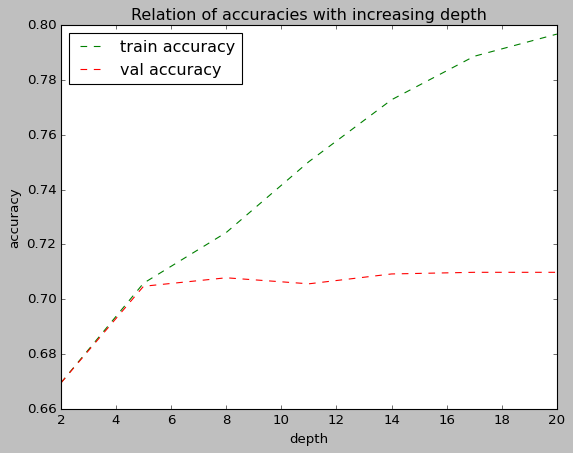

In [ ]:
plt.figure()

plt.plot(depths,
         depth_train_accuracies,
         color='g',
         linestyle='dashed',
         label='train accuracy')
plt.plot(depths, 
         depth_val_accuracies, 
         color='r',
         linestyle='dashed', 
         label='val accuracy')

plt.xlabel('depth')
plt.ylabel('accuracy')
plt.title('Relation of accuracies with increasing depth')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# looking at the plot, we can deduce depth=5 to be the best depth
def get_best_model_classfication_report(df, n_splits=5,
                                        output_heatmap=True,
                                        include_support=False,
                                        cmap='Spectral'):
    best_val_accuracy = [0, 0] # keep record of best acc and the kfold
    for i in range(n_splits):
        _, _, val_accuracy, val_pred = train(df,
                                             i,
                                             max_depth=5, 
                                             return_pred=True)
        
        if val_accuracy > best_val_accuracy[0]:
            best_val_accuracy = [val_accuracy, i]
            best_pred = val_pred

    y = df[df['kfold'] == best_val_accuracy[1]]['targets'].values
    report = metrics.classification_report(y,
                                        best_pred,
                                        output_dict=True if output_heatmap else False)

    if output_heatmap and not include_support:
        return sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T,
                            annot=True,
                            cmap=cmap)

    elif output_heatmap and include_support:
        return sns.heatmap(pd.DataFrame(report).iloc[:, :].T,
                           annot=True,
                           cmap=cmap)

    return report     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


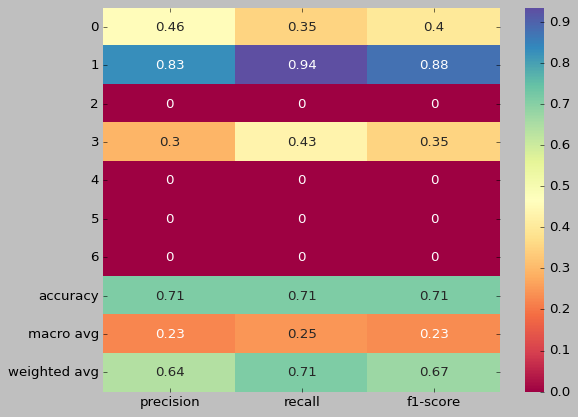

In [ ]:
report = get_best_model_classfication_report(df,
                                         n_splits=5, 
                                         output_heatmap=True, 
                                         include_support=False)
report

In [ ]:
# we can already see that the P/R for class 1 is very high compared to others for the reason
# that this classifier is very biased due to the skew towards class 1